In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from timm.scheduler import CosineLRScheduler
import joblib
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import wandb
from copy import copy
import json
import random
import os

sys.path.append("../..")
from src.dataset.two_branch_model import preprocess_sequence, pad_sequences_torch, CMI3Dataset
from src.dataset.transform import Augment
from src.model.two_branch_model import TwoBranchModel
from src.model.three_branch_model import ThreeBranchModel
from src.utils.train_utils import EarlyStopping, EMA
from src.utils.config import CFG as config
from src.dataset.features import FE

In [3]:
CFG = config("../input/config.yaml")
CFG.RAW_DIR = Path(CFG.RAW_DIR)
CFG.PRETRAINED_DIR = Path("../result")
CFG.EXPORT_DIR = Path(CFG.EXPORT_DIR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("▶ INFERENCE MODE – loading artefacts from", CFG.PRETRAINED_DIR)
feature_cols = np.load(CFG.PRETRAINED_DIR / "feature_cols.npy", allow_pickle=True).tolist()
demo_feature_cols = np.load(CFG.PRETRAINED_DIR / "demo_features.npy", allow_pickle=True).tolist()
pad_len = int(np.load(CFG.PRETRAINED_DIR / "sequence_maxlen.npy"))
scaler = joblib.load(CFG.PRETRAINED_DIR / "scaler.pkl")
demo_scaler = joblib.load(CFG.PRETRAINED_DIR / "demo_scaler.pkl")
gesture_classes = np.load(CFG.PRETRAINED_DIR / "gesture_classes.npy", allow_pickle=True)

imu_cols = [c for c in feature_cols if not (c.startswith('thm_') or c.startswith('tof_'))]
tof_cols = [c for c in feature_cols if c.startswith('tof_')]
thm_cols = [c for c in feature_cols if c.startswith('thm_')]

# Reorder feature columns to match model expectation: IMU -> TOF -> THM
feature_cols_ordered = imu_cols + tof_cols + thm_cols

    
# Load model
MODELS = [f'gesture_threebranchmodel_fold{i}.pth' for i in range(5)]
    
models = []
for path in MODELS:
    checkpoint = torch.load(CFG.PRETRAINED_DIR / path, map_location=device)
        
    model = ThreeBranchModel(
        checkpoint['pad_len'], 
        checkpoint['imu_dim'], 
        checkpoint['tof_dim'], 
        checkpoint['thm_dim'],
        checkpoint['demo_dim'],
        checkpoint['n_classes']
        ).to(device)
        
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    models.append(model)

▶ INFERENCE MODE – loading artefacts from ../result


/home/kei/python/ml_competition/CMI2025/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


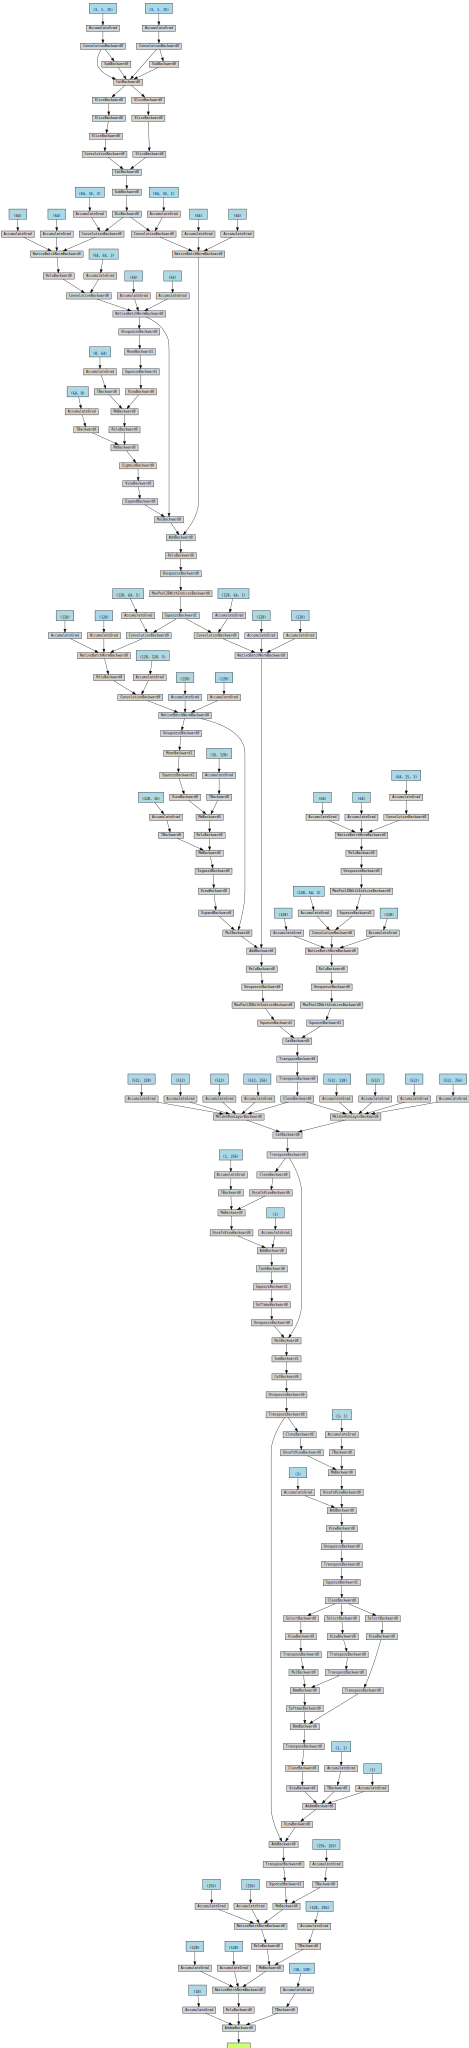

In [5]:
import torchviz
torchviz.make_dot(var=model(torch.rand(64, 100, 32), torch.rand(64, 7)))